In [1]:
# !pip install xgboost

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

In [3]:
## combined

In [4]:
# # Names of the aggregation functions
# agg_funcs = ['min', 'mean', 'max', 'sum']
# # Initialize an empty DataFrame for concatenated features
# concatenated_features = pd.DataFrame()
# for agg_func in agg_funcs:
#     # Load each dataframe
#     df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
#     # Update column names with 'agg_func' prefix for all columns except the last one
#     df.columns = [f"{agg_func}_{col}" if col != 'energy' else col for col in df.columns]
#     # Concatenate features (all columns except the last one)
#     concatenated_features = pd.concat([concatenated_features, df.iloc[:, :-1]], axis=1)
# # Assuming the target column ('energy') is identical in all dataframes, take it from the first dataframe
# target_column = pd.read_pickle('datasets/df_ocp_dpp_min.pickle')['energy']
# # Combine the concatenated features with the target column
# final_df = pd.concat([concatenated_features, target_column], axis=1)
# print(final_df.shape)
# # Save the final dataframe as a pickle file
# final_df.to_pickle('datasets/df_ocp_dpp_combined.pickle')

In [5]:
## performance evaluation

count    329863.000000
mean         -1.404898
std           2.047871
min          -9.982733
25%          -2.824951
50%          -1.591082
75%          -0.209614
max           9.999101
Name: energy, dtype: float64


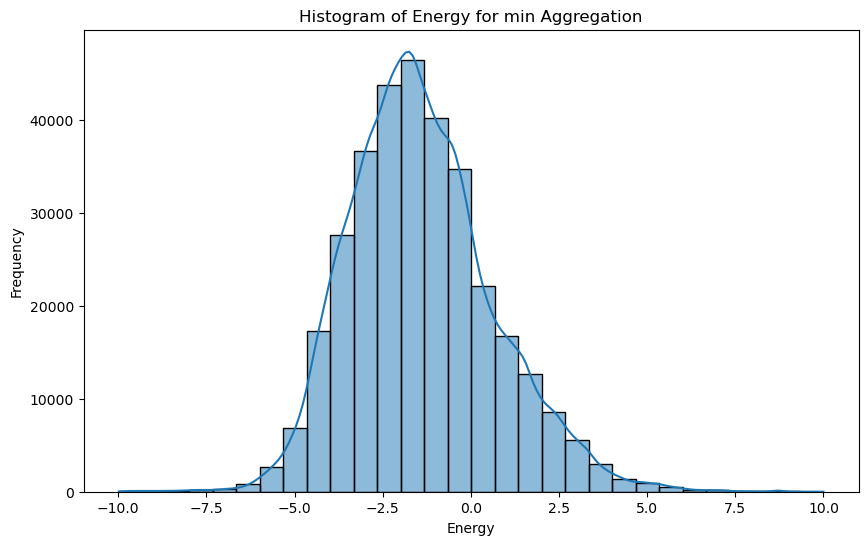

In [6]:
agg_funcs = ['min', 'mean', 'max', 'sum', 'combined']
for agg_func in agg_funcs[:1]:
    # Load dataframe
    df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
    print(df['energy'].describe())
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df['energy'], bins=30, kde=True)
    plt.title(f'Histogram of Energy for {agg_func} Aggregation')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.show()

(329863, 257)
-3.452768568539208 0.6429725189675337 (229033, 257)
0.3 6 400 0.5980135464303564


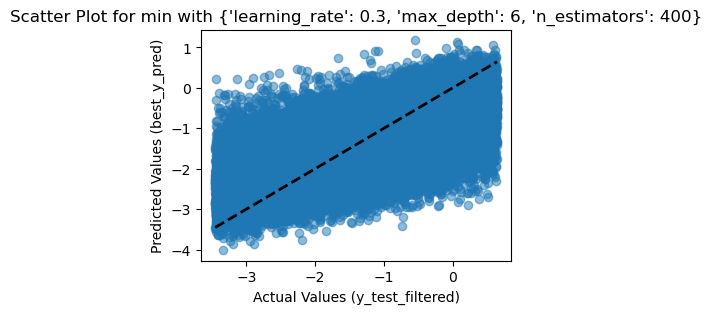

(329863, 257)
-3.452768568539208 0.6429725189675337 (229033, 257)
0.3 6 400 0.7096049655372281


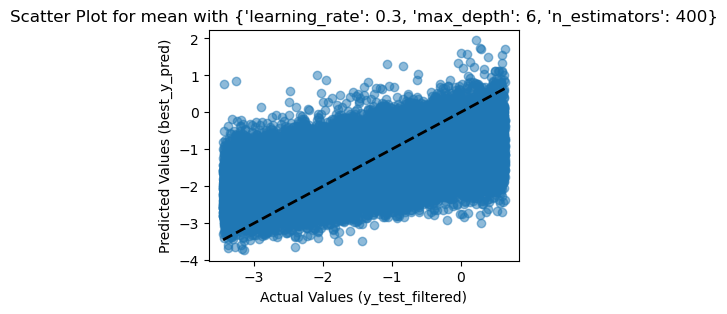

(329863, 257)
-3.452768568539208 0.6429725189675337 (229033, 257)
0.3 6 400 0.5704661663611322


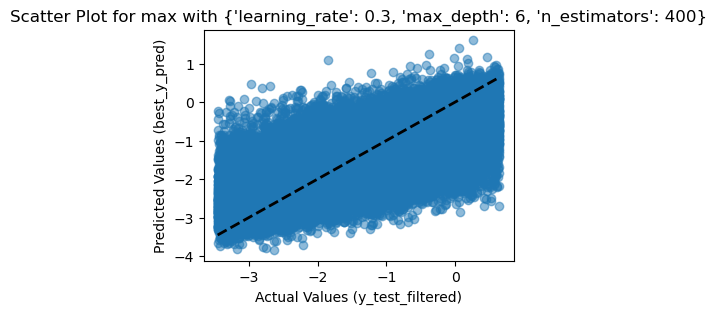

(329863, 257)
-3.452768568539208 0.6429725189675337 (229033, 257)
0.3 6 400 0.7292301107100676


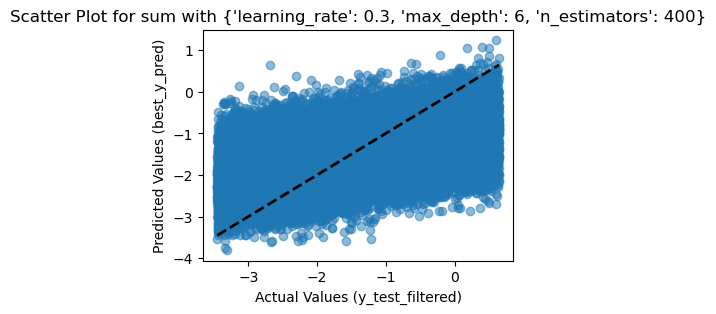

(329863, 1025)
-3.452768568539208 0.6429725189675337 (229033, 1025)
0.3 6 400 0.5545747454057227


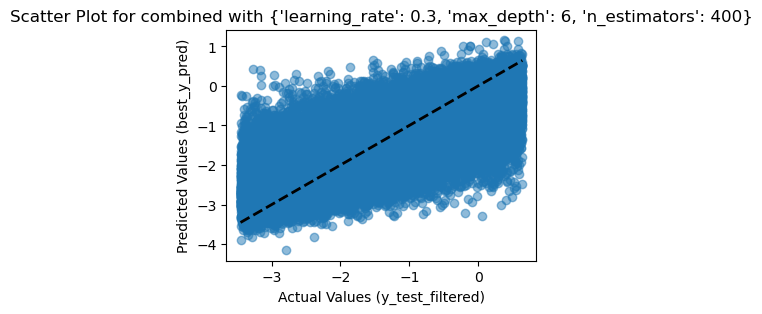

In [7]:
hyperparams = {
    'learning_rate': [0.3],
    'max_depth': [6],
    'n_estimators': [400]
}
agg_funcs = ['min', 'mean', 'max', 'sum', 'combined']
best_scores = {}
best_configs = {}

for agg_func in agg_funcs:
    # Load dataframe
    df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
    ########################################################################## NO NEED
    print(df.shape)
    # Calculate the mean and standard deviation
    mean_energy = df['energy'].mean()
    std_energy = df['energy'].std()
    ## todo: 
    lower_bound = mean_energy - 1 * std_energy
    upper_bound = mean_energy + 1 * std_energy
    # Filter the DataFrame
    df = df[(df['energy'] >= lower_bound) & (df['energy'] <= upper_bound)]
    print(lower_bound, upper_bound, df.shape)
    ##########################################################################
    
    # Splitting into features and target
    X = df.iloc[:, :-1]  # Assuming last column is 'energy'
    y = df['energy']  
    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Reset the index of y_test here, outside the loop
    y_test_reset = y_test.reset_index(drop=True)
    
    # Variables to store the best score and alpha for the current dataframe
    best_score = float('inf')
    best_config = None
    best_y_pred = None

    for lr in hyperparams['learning_rate']:
        for depth in hyperparams['max_depth']:
            for n_est in hyperparams['n_estimators']:
                # Initialize and train model
                model = xgb.XGBRegressor(learning_rate=lr, max_depth=depth, n_estimators=n_est)
                model.fit(X_train, y_train)

                # Make predictions and evaluate
                y_pred = model.predict(X_test)
                ## todo: 
                # valid_pred_mask = (y_pred >= -20) & (y_pred <= 20)
                # y_pred_filtered = y_pred[valid_pred_mask]
                # y_test_filtered = y_test_reset[valid_pred_mask]
                y_pred_filtered = y_pred
                y_test_filtered = y_test_reset
                
                score = mean_absolute_error(y_test_filtered, y_pred_filtered)
                print(lr, depth, n_est, score)
                if score < best_score:
                    best_score = score
                    best_config = {'learning_rate': lr, 'max_depth': depth, 'n_estimators': n_est}
                    best_y_pred = y_pred_filtered

    # Store the best score and configuration for the current dataframe
    best_scores[agg_func] = best_score
    best_configs[agg_func] = best_config

    # Plot y_test_filtered vs best_y_pred
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test_filtered, best_y_pred, alpha=0.5)
    plt.xlabel('Actual Values (y_test_filtered)')
    plt.ylabel('Predicted Values (best_y_pred)')
    plt.title(f'Scatter Plot for {agg_func} with {best_config}')
    plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'k--', lw=2)
    plt.show()

In [8]:
# Print the best hyperparameter configuration and score for each dataframe
for agg_func in agg_funcs:
    print(f"Best hyperparameters for {agg_func}: {best_configs[agg_func]} with score: {best_scores[agg_func]}")

# Assuming y_test is defined in your context and represents the test target values
print(f"Mean absolute value of y_test: {np.mean(np.abs(y_test))}")

Best hyperparameters for min: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400} with score: 0.5980135464303564
Best hyperparameters for mean: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400} with score: 0.7096049655372281
Best hyperparameters for max: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400} with score: 0.5704661663611322
Best hyperparameters for sum: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400} with score: 0.7292301107100676
Best hyperparameters for combined: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 400} with score: 0.5545747454057227
Mean absolute value of y_test: 1.5924107243626524
